# Courses recommendation system
# I. Extract, transform and load

This is the first part of the Udacity Data Science Nanodegree capstone project, which consists in the creation of a course recommendation system.

## Introduction

[Emagister](https://www.emagister.com) is a company whose objective is to be a meeting point for students and course providers and they aim to do so by helping people find the right training. That's why the recommender system is one of the most important parts of the web. So the main motivation of this project is to improve the current recommendation system.

### Data used for the project

The data that will be worked on in this project are real data extracted from the [Emagister UK](https://www.emagister.co.uk) database. As an employee of Emagister, I requested authorization from the company to use the data, after consulting with our lawyers, the company permitted me. 

For security and legal reasons, user data is encrypted. 

### The recommender system

The recommendations are based on the following four methods of recommendations:

* Knowledge based recommendations
* Content based filtering
* Neighborhood based collaborative filtering
* Model based collaborative filtering

The project is divided in two parts:

1. ETL pipeline (this notebook)
2. Exploratory data analysis
3. Make recommendations
4. A demo web application

#### ETL pipeline

The pipeline retrieves raw data from database, then performs the data wrangling process on this data and finally loads the resulting formatted data to database and files, ready to be used in the web application.


#### Exploratory data analysis

Once the data is cleaned, is time to perform an exploratory data analysis. I will search for patterns and trends in data and I will create visualizations for this data as well.

#### Make recommendations

After the exploratory data analysis, is time to play around with structures created in the first part and trying to make recommendations.

#### Demo web

The observations and models derived from the ETL phase and analysis of the project, have been put into practice in a web application that can be accessed [here](https://courses-recommender.herokuapp.com/).

## Dependencies
To run this project properly, you need the following:

* Python >=3.5
* numpy 1.18.1
* pandas 0.24.2
* scikit-learn 0.20.3
* sqlalchemy 1.3.2
* matplotlib 3.0.3
* halo 0.0.28 (Spinner for terminal. [PyPi](https://pypi.org/project/halo/))
* pymysql 0.9.3 (Python MySQL client library. [PyPi](https://pypi.org/project/PyMySQL/))

In addition you need to install `texcptulz`, a library designed to transform the raw ingested text into a form that is ready for calculation and modelling.
This library has been developed by me for this project. To install `texcptulz` run the following command:

`pip install texcptulz`

More information [here](https://pypi.org/project/texcptulz/).

# Start ETL Process
## 1 Import libraries

In [138]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sqlalchemy import types as sql_types
from txtools.normalizer import clean_text
from txtools.utils import LangDetector
from db_utils import connection 
from common import requested_courses


## 2 Retrieving Leads
I will get a sample of leads from Emagister database gererated in the last year. The sample table `leads` contains approximately 40000 leads.

In [68]:
leads_query = '''SELECT user_id,
    course_id,
    course_title,
    course_description,
    course_category,
    center,
    created_on
FROM leads
ORDER BY created_on DESC
'''

leads_df = pd.read_sql_query(leads_query, con=connection())

In [69]:
leads_df.head()

,user_id,course_id,course_title,course_description,course_category,center,created_on
0,ed53e691ee322e24d8cc843fff68ebc6,170631539,Aviation Engineering - BEng (Hons),The Aviation Engineering programme aims to tra...,Engineering,The Hong Kong Polytechnic University,2020-01-05 13:13:03
1,ed53e691ee322e24d8cc843fff68ebc6,170631539,Aviation Engineering - BEng (Hons),The Aviation Engineering programme aims to tra...,Engineering,The Hong Kong Polytechnic University,2020-01-05 10:59:56
2,ed53e691ee322e24d8cc843fff68ebc6,170631539,Aviation Engineering - BEng (Hons),The Aviation Engineering programme aims to tra...,Engineering,The Hong Kong Polytechnic University,2020-01-04 21:10:52
3,ed53e691ee322e24d8cc843fff68ebc6,170609773,Master of Leadership in Development Finance - ...,Boost your career with an international degree...,Accounting,Frankfurt School of Finance & Management,2020-01-03 20:22:46
4,ed53e691ee322e24d8cc843fff68ebc6,170654780,New to Web Design,Our New to Web Design course bundle will teach...,Other Web Design,IT Online Learning,2020-01-01 20:29:13


### 2.1 Search for duplicated
Duplicated leads, in this case is when a user generates more than one lead into the same course

In [70]:
leads_df.duplicated(['user_id', 'course_id']).sum()

255

I will remove the duplicates keeping the first lead generated by the user, that's the one that was created earlier.

In [71]:
leads_df.drop_duplicates(['user_id', 'course_id'], inplace=True, keep='last')

In [72]:
leads_df.duplicated(['user_id', 'course_id']).sum()

0

### 2.2 Search for missing values

In [73]:
leads_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39782 entries, 4 to 40036
Data columns (total 7 columns):
user_id               39782 non-null object
course_id             39782 non-null int64
course_title          39782 non-null object
course_description    38253 non-null object
course_category       39782 non-null object
center                39782 non-null object
created_on            39782 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 2.4+ MB


There are 1529 leads to courses without descriptions

In [74]:
leads_df[leads_df['course_description'].isnull()]['course_id'].nunique()

653

Or 653 courses without description. I will keep this rows in the dataframe because the information provided by a lead-course pair is very valuable even if the course has no description. Anyway, I will replace the null value with an empty string

In [75]:
leads_df['course_description'] = leads_df['course_description'].fillna('')

In [77]:
leads_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39782 entries, 4 to 40036
Data columns (total 7 columns):
user_id               39782 non-null object
course_id             39782 non-null int64
course_title          39782 non-null object
course_description    39782 non-null object
course_category       39782 non-null object
center                39782 non-null object
created_on            39782 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 2.4+ MB


### 2.3 Convert `course_id` column type to string

In [80]:
leads_df['course_id'] = leads_df['course_id'].astype(str)

In [81]:
leads_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39782 entries, 4 to 40036
Data columns (total 7 columns):
user_id               39782 non-null object
course_id             39782 non-null object
course_title          39782 non-null object
course_description    39782 non-null object
course_category       39782 non-null object
center                39782 non-null object
created_on            39782 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(6)
memory usage: 2.4+ MB


## 3 Retrieving reviews
The reviews come from the Emagister database and are a sample of those that have been made in the last 18 months.

In [82]:
reviews_query = '''SELECT user_id,
    course_id,
    course_title,
    course_category,
    course_description,
    center,
    rating,
    created_on
FROM reviews
ORDER BY created_on DESC
'''

reviews_df = pd.read_sql_query(reviews_query, con=connection())

In [84]:
reviews_df.head()

,user_id,course_id,course_title,course_category,course_description,center,rating,created_on
0,2b8d8517932c25c11858c48b7563d1f0,170378812,SIA Bodyguard Training,Self-development,The SIA approved Close Protection course is th...,Clinton Training Ltd,6,2019-12-26 17:40:22
1,6c4962141ae920e56739fd36a1383333,170363242,NVQ Tiling courses - Free - Funded by Government,Construction Trades,"CSCS Skill Card. <br />Suitable for: Employed,...",Censura Consulting,10,2019-12-26 17:18:13
2,52d477c4ebcb10e3368a2fa396d97df7,170628943,Bachelor in Aviation Management,Energy and Utilities,Immerse yourself in the world of aviation mana...,IUBH University of Applied Sciences,10,2019-12-26 14:51:26
3,8921583e8a24ca92d0ae4b65d86d6c6a,170385895,Forensics,Police,Forensic science is a very exciting area as sh...,International Career Institute,10,2019-12-26 11:27:27
4,6c4962141ae920e56739fd36a1383333,170363242,NVQ Tiling courses - Free - Funded by Government,Construction Trades,"CSCS Skill Card. <br />Suitable for: Employed,...",Censura Consulting,10,2019-12-26 11:25:08


### 3.1 Search for outliers in `rating` column

In [85]:
reviews_df['rating'].describe()

count    19160.000000
mean         9.301461
std          1.142509
min          2.000000
25%          8.000000
50%         10.000000
75%         10.000000
max         10.000000
Name: rating, dtype: float64

There seems to be no outliers

### 3.2 Search for duplicated rows

In [86]:
reviews_df.duplicated(['user_id', 'course_id']).sum()

185

There are 185 duplicated reviews. I will remove them keeping the first review made by the user.

In [87]:
reviews_df.drop_duplicates(['user_id', 'course_id'], inplace=True, keep='last')

In [88]:
reviews_df.duplicated(['user_id', 'course_id']).sum()

0

### 3.3 Search for missing values

In [89]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18975 entries, 0 to 19159
Data columns (total 8 columns):
user_id               18975 non-null object
course_id             18975 non-null int64
course_title          18975 non-null object
course_category       18975 non-null object
course_description    18919 non-null object
center                18975 non-null object
rating                18975 non-null int64
created_on            18975 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 1.3+ MB


There are 56 reviews to courses without description.

In [90]:
reviews_df[reviews_df['course_description'].isnull()]['course_id'].nunique()

23

Or 23 courses without description. I will do the same as in the previous case. I will keep the rows to keep the information of each review. I will replace the null value with an empty string in this dataframe too.

In [99]:
reviews_df['course_description'] = reviews_df['course_description'].fillna('')

In [100]:
reviews_df[reviews_df['course_description'].isnull()]['course_id'].nunique()

0

### 3.4 Convert `course_id` column type to string

In [101]:
reviews_df['course_id'] = reviews_df['course_id'].astype(str)

In [102]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18975 entries, 0 to 19159
Data columns (total 8 columns):
user_id               18975 non-null object
course_id             18975 non-null object
course_title          18975 non-null object
course_category       18975 non-null object
course_description    18975 non-null object
center                18975 non-null object
rating                18975 non-null int64
created_on            18975 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 1.3+ MB


In [103]:
reviews_df.head()

,user_id,course_id,course_title,course_category,course_description,center,rating,created_on
0,2b8d8517932c25c11858c48b7563d1f0,170378812,SIA Bodyguard Training,Self-development,The SIA approved Close Protection course is th...,Clinton Training Ltd,6,2019-12-26 17:40:22
2,52d477c4ebcb10e3368a2fa396d97df7,170628943,Bachelor in Aviation Management,Energy and Utilities,Immerse yourself in the world of aviation mana...,IUBH University of Applied Sciences,10,2019-12-26 14:51:26
3,8921583e8a24ca92d0ae4b65d86d6c6a,170385895,Forensics,Police,Forensic science is a very exciting area as sh...,International Career Institute,10,2019-12-26 11:27:27
4,6c4962141ae920e56739fd36a1383333,170363242,NVQ Tiling courses - Free - Funded by Government,Construction Trades,"CSCS Skill Card. <br />Suitable for: Employed,...",Censura Consulting,10,2019-12-26 11:25:08
5,6c4962141ae920e56739fd36a1383333,170567406,Level 2 Diploma in Wall and Floor Tiling,Construction Trades,Level 2 Diploma in Wall and Floor Tiling\n« Re...,Hackney Community College,10,2019-12-26 11:19:59


## 4 Create courses dataframe

I will create a dataframe of unique courses from the reviews and leads dataframes

In [104]:
keep_columns = ['course_id', 'course_title', 'course_description', 'course_category', 'center']

courses_from_leads = leads_df[keep_columns].drop_duplicates('course_id')
courses_from_reviews = reviews_df[keep_columns].drop_duplicates('course_id')

courses_df = pd.merge(courses_from_leads, courses_from_reviews,
                      left_on=keep_columns, 
                      right_on=keep_columns, 
                      how='outer')

# Remove duplicates
courses_df.drop_duplicates('course_id', inplace=True)

courses_df.head()

,course_id,course_title,course_description,course_category,center
0,170654780,New to Web Design,Our New to Web Design course bundle will teach...,Other Web Design,IT Online Learning
1,170565168,Wordpress Website & Blog Builder,"Right now, there are about 6.7 million blogs o...",Other Web Design,International Open Academy
2,170079653,Office Skills Diploma,If you want to gain practical skills in order ...,Office Systems,Pitman Training London
3,170623853,Web Design Bundle Course - CPD Certified & IAO...,Web design is not only about planning and desi...,HomeSite,John Academy
4,170418482,Webmaster HTML & CSS Web Design Course,Emagister presents the Webmaster course - HTML...,Other Web Design,Distance Learning Centre


In [105]:
courses_df['course_id'].nunique()

17527

In [106]:
courses_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17527 entries, 0 to 17534
Data columns (total 5 columns):
course_id             17527 non-null object
course_title          17527 non-null object
course_description    17527 non-null object
course_category       17527 non-null object
center                17527 non-null object
dtypes: object(5)
memory usage: 821.6+ KB


Renaming the columns

In [107]:
courses_df.rename(columns={'course_id': 'id', 'course_title': 'title',
                          'course_description': 'description', 'course_category': 'category'},
                 inplace=True)

Cleaning text columns

In [108]:
courses_df['title'] = courses_df['title'].apply(clean_text)
courses_df['description'] = courses_df['description'].apply(lambda x: clean_text(x) if x else x)
courses_df['center'] = courses_df['center'].apply(clean_text)

### 4.1 Content language

Sometimes the course descriptions are not in the correct language. I will detect the language, and I will discard the courses with the description in a language other than English. <span style="color:red">**This process takes about 45 minutes on a MacBook Pro (2.3 GHz Intel Core i5, 16 GB RAM)**</span>

In [109]:
lang_detector = LangDetector()
def get_lang(text):
    """ 
    Detects the language of a text
    
    :param text str: Text of which we want to know the language
                          
    :return str: Language ISO 639-1 code
    """
    if not text:
        return LangDetector.DEFAULT_LANGUAGE
    
    try: 
        return lang_detector.iso_639_1_code(text)
    except ValueError:
        return LangDetector.DEFAULT_LANGUAGE

In [110]:
courses_df['lang'] = courses_df['description'].apply(get_lang)

In [111]:
not_english_courses = courses_df[courses_df['lang'] != 'en']
not_english_courses.head()

,id,title,description,category,center,lang
56,170573636,Criminologa,El curso est dirigido a todos aquellos que pro...,Criminal Law,Deka Online Courses,es
66,170661935,Business Model Innovation,Design Thinking parte de la idea de que la mej...,Business Management,Design Thinking Sweden,es
78,170232997,Introduction to Basic TIG Welding,To get basic skills in TIG welding. Suitable f...,Engineering,Allister Moore Weld Training Centre,xx
89,170573635,Educador Cinfilo,El curso est dirigido a todos aquellos que pro...,Animal Health,Deka Online Courses,es
120,170623758,Masaje y Masoterapia,El curso est dirigido a todos aquellos que pro...,Medicine,Deka Online Courses,es


Remove not english courses and column `lang`.

In [112]:
courses_df.drop(courses_df[courses_df['lang'] != 'en'].index, inplace=True)
courses_df.drop('lang', axis=1, inplace=True)

Remove courses written in a non-English language from `reviews_df` and `leads_df`

In [113]:
reviews_df = reviews_df[~reviews_df['course_id'].isin(not_english_courses['id'].values)]
leads_df = leads_df[~leads_df['course_id'].isin(not_english_courses['id'].values)]

### 4.2 Save leads and reviews to database
**Save leads**

In [135]:
# Creates the 'clean_leads' table

leads_df = leads_df[['user_id', 'course_id', 'created_on']]

sql_drop = 'DROP TABLE IF EXISTS `clean_leads`'
c = connection().execute(sql_drop)

sql_create = """CREATE TABLE clean_leads
(
    `user_id`    CHAR(36) NOT NULL,
    `course_id`  VARCHAR(12) NOT NULL,
    `created_on` DATETIME NOT NULL,
    PRIMARY KEY (`user_id`, `course_id`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8
"""
c = connection().execute(sql_create)

# Save leads to database
leads_df.to_sql('clean_leads', con=connection(), if_exists='append', index=False)

**Save reviews**

In [136]:
# Creates the 'clean_reviews' table

reviews_df = reviews_df[['user_id', 'course_id', 'rating', 'created_on']]

sql_drop = 'DROP TABLE IF EXISTS `clean_reviews`'
c = connection().execute(sql_drop)

sql_create = """CREATE TABLE `clean_reviews`
(
    `user_id`    CHAR(36) NOT NULL,
    `course_id`  VARCHAR(12) NOT NULL,
    `rating`     INT NOT NULL,
    `created_on` DATETIME NOT NULL,
    PRIMARY KEY (`user_id`, `course_id`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8
"""
c = connection().execute(sql_create)

# Save reviews to database
reviews_df.to_sql('clean_reviews', con=connection(), if_exists='append', index=False)


### 4.2 Computing the weighted rating

I will add a column to the courses_df indicating the weighted rating for each course. I will also add a column indicating the number of reviews of each course.

To compute the weighted rating, I will use the IMDB's weighted rating formula to calculate the [Top Rated 250 titles](https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#calculatetop):

$$
weighted\space rating\space(wr) = (\dfrac{v}{v+m}\times{R})+(\dfrac{m}{v+m}\times{C})
$$

Where:

- $v$ is the number of reviews received by the course
- $m$ is the minimum number of reviews required for the course to be listed in the top
- $R$ is the average rating of the course
- $C$ is the average rating of all the courses in the dataset

I can compute $v$, $R$ and $C$, but $m$ is a number that does not depend on any calculation. In IMDB, this number is 25,000. In Emagister, we award a prize to the most valued study centers and schools. One of the conditions to qualify for the prize is that each course has at least 25 reviews, so I will use 25 as a value for $m$.

With this calculation, I will take into account the number of reviews each course has received to rank courses.

In [114]:
def average_rating(course_id, df):
    """ 
    Computes the average rating of a course
    
    :param course_id str: Course id
                          
    :return float|np.nan: The average rating of a course or np.nan if the course has no rating
    """
    df = df[df['course_id'] == course_id]
    
    if df.shape[0] == 0:
        return np.nan
    
    return df['rating'].mean()


def num_reviews(course_id, df):
    """ 
    Counts the number of reviews of a course
    
    :param course_id str: Course id
                          
    :return int: The number of reviews of a course
    """
    df = df[df['course_id'] == course_id]
    
    return df.shape[0]


def all_avg_rating(df):
    """ 
    Computes the average rating of all courses (C)
    
    :param df DataFrame: Courses dataframe
                          
    :return float: The average rating of all courses in DataFrame
    """
    df = df[~df['avg_rating'].isnull()]
        
    return df['avg_rating'].mean()


def weighted_rating(row, C, m):
    """ 
    Computes the weighted rating of a course
    
    :param row DataFrame row: A DataFrame row representing a course
    :param C float: The average rating of all the courses in the dataset
    :param m int: The minimum number of reviews required for the course to be listed
                          
    :return float: The average rating of all courses in DataFrame
    """
    v = row['num_reviews']
    R = row['avg_rating']
    
    if v == 0 and np.isnan(R):
        return np.nan
    
    wr = (v * R / (v + m)) + (m * C / (v + m))
    
    return wr

I must first calculate the rating average of each course:

In [115]:
courses_df['avg_rating'] = courses_df['id'].apply(average_rating, args=(reviews_df,))

Then, I count the number of reviews received for each course:

In [116]:
courses_df['num_reviews'] = courses_df['id'].apply(num_reviews, args=(reviews_df,)).astype(int)

And finally, I will calculate the weighted rating. Using 25 as a value for $m$, as I explained above.

In [117]:
C = all_avg_rating(courses_df)
m = 25


courses_df['weighted_rating'] = courses_df.apply(weighted_rating, axis=1, args=(C, m,))

In [118]:
courses_df.sort_values('weighted_rating', ascending=False).head()

,id,title,description,category,center,avg_rating,num_reviews,weighted_rating
14544,170575432,Aerospace Engineering MEng (Hons) 4 years,The first two years of this course give you a ...,Engineering,University of Bath,10.0,44,9.731074
2949,170601662,Excel Intermediate Course,Course summary This Excel course is offered on...,Excel,PCWorkshops,10.0,44,9.731074
13730,170644676,Corporate English Training,Corporate English Training The London School o...,English,The London School of English,10.0,29,9.656372
11903,170040286,Drafting and Negotiating International Agency ...,This two-day interactive course is targeted a...,International Law,Falconbury Ltd,10.0,27,9.643155
11900,170040323,Drafting Commercial Contracts,Do you want to negotiate and draft clear and c...,Business Law,Falconbury Ltd,10.0,26,9.636158


### 4.3 Add number of leads to courses_df
Now, I will add a column to the courses_df indicating the number of leads generated for each course.

In [119]:
lead_counts = leads_df.groupby('course_id').count()['user_id']
def number_of_leads(course_id):
    """ 
    Counts the number of leads generated by a course
    
    :param course_id str: Course id
                          
    :return int: The number of leads generated by a course
    """
    try:
        return lead_counts.loc[course_id]
    except KeyError:
        return 0

In [120]:
courses_df['number_of_leads'] = courses_df['id'].apply(number_of_leads).astype(int)

In [121]:
courses_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17323 entries, 0 to 17534
Data columns (total 9 columns):
id                 17323 non-null object
title              17323 non-null object
description        17323 non-null object
category           17323 non-null object
center             17323 non-null object
avg_rating         7045 non-null float64
num_reviews        17323 non-null int64
weighted_rating    7045 non-null float64
number_of_leads    17323 non-null int64
dtypes: float64(2), int64(2), object(5)
memory usage: 1.3+ MB


### 4.4 Save courses to database

In [134]:
# Creates the 'courses' table

sql_drop = 'DROP TABLE IF EXISTS `courses`'
c = connection().execute(sql_drop)

sql_create = """CREATE TABLE `courses` (
  `id` varchar(9) NOT NULL,
  `title` text,
  `description` text,
  `center` varchar(100) NOT NULL,
  `avg_rating` double DEFAULT NULL,
  `num_reviews` int(11) DEFAULT NULL,
  `weighted_rating` double DEFAULT NULL,
  `number_of_leads` int(11) DEFAULT NULL,
  `category_id` int(11) NOT NULL,
  PRIMARY KEY (`id`),
  KEY `courses_category_id_index` (`category_id`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8
"""
c = connection().execute(sql_create)

# Save courses to database
courses_df.to_sql('courses', con=connection(), if_exists='append', index=False)

## 5 Create a categories dataframe

I will create a categories DataFrame to store the categories of the courses. This will be useful in the web application to navigate through the different categories. 

In [122]:
categories = courses_df['category'].unique()

In [123]:
categories_df = pd.DataFrame(categories, columns=['name']).reset_index()

In [124]:
categories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 2 columns):
index    253 non-null int64
name     253 non-null object
dtypes: int64(1), object(1)
memory usage: 4.0+ KB


In [125]:
# Convert the index into a column
categories_df.rename(columns={'index': 'id'}, inplace=True)

In [126]:
categories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 2 columns):
id      253 non-null int64
name    253 non-null object
dtypes: int64(1), object(1)
memory usage: 4.0+ KB


In [127]:
# This is to avoid identifiers with 0 value
categories_df['id'] = categories_df['id'].apply(lambda x: x + 1)

In [128]:
categories_df.head()

,id,name
0,1,Other Web Design
1,2,Office Systems
2,3,HomeSite
3,4,Engineering
4,5,Marketing Operations


### 5.1 Add category id to courses dataframe

In [129]:
def category_id(category_name):
    """Search for a category by name in the category data frame and return its identifier

    :param category_name: Category name
    :return: The category id
    """
    return categories_df[categories_df['name'] == category_name]['id'].values[0]
    

In [130]:
courses_df['category_id'] = courses_df['category'].apply(category_id)

In [131]:
# Removes the category name from courses_df
courses_df.drop('category', inplace=True, axis=1)

### 5.2 Save categories to database

In [133]:
# Creates the 'categories' table

sql_drop = 'DROP TABLE IF EXISTS `categories`'
c = connection().execute(sql_drop)

sql_create = """CREATE TABLE `categories` (
  `id` int(11) NOT NULL,
  `name` varchar(200) NOT NULL,
  PRIMARY KEY (`id`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8
"""
c = connection().execute(sql_create)

# Save categories to database
categories_df.to_sql('categories', con=connection(), if_exists='append', index=False)


## 6 Create a course content similarity matrix

I will create a similarity matrix for courses content. I will use the title and the description to compare the courses with each other. In the matrix, columns and rows indexes will be the course id and the intersection will be the similarity between them. The range of values will be between 0 and 1, where 0 means totally different and 1 means that the content is identical.

In [17]:
def create_similarity_matrix(df, sample_len=None):
    """ 
    Creates a course similarity matrix
    
    :param df DataFrame: courses dataframe. Must include title and description columns
    :param sample_len: Maximum number of courses used to create the matrix. If `None`, all courses in DataFrame
            will be used.
    :return np.ndarray: An m x m matrix representing the course similarities, where m is the number of courses.
        Example of a similarity matrix:
        
         [[0.99999994 0.         0.13075474 0.02665992]
          [0.         1.         0.00812627 0.00331377]
          [0.13075474 0.00812627 1.         0.0069054 ]
          [0.02665992 0.00331377 0.0069054  1.        ]]
          
        rows and columns represents a course, the elements in the matrix, represent the similarity between them.
    """
    if not sample_len:
        course_content = df['title'].str.cat(df['description'], sep='. ').values
    else:
        course_content = df['title'].str.cat(df['description'], sep='. ').head(sample_len).values
    
    model = Pipeline([
        ('norm', TextNormalizer()),
        ('sim', Similarity())
    ])
    
    return model.fit_transform(course_content)
    
    
def create_similarity_df(df, min_similarity=0.5, sample_len=None):
    """
    Creates a course similarity DataFrame from a similarity matrix
    
    :param df DataFrame: Courses dataframe. Must include title and description columns
    :param min_similarity float: Minimum similarity to be included in DataFrame
    :param sample_len int: Maximum number of courses that will be included in the matrix
    
    :return DataFrame: a dataframe with following columns:
        a_course str: course id
        another_course str: course id
        similarity float: similarity between courses
    """
    sim_list = []
    sim_matrix = create_similarity_matrix(df, sample_len=sample_len)
    
    for idx, similarities in enumerate(sim_matrix):
        a_course_id = df.iloc[idx]['id']
        
        for idx_sims, sim_score in enumerate(similarities):
            if idx == idx_sims:
                continue

            if sim_score < min_similarity:
                continue

            another_course_id = df.iloc[idx_sims]['id']

            sim_list.append({'a_course_id': a_course_id, 
                             'another_course_id': another_course_id, 
                             'similarity': sim_score})

    return pd.DataFrame(sim_list)

I will create a similarity matrix with a sample of 50 courses

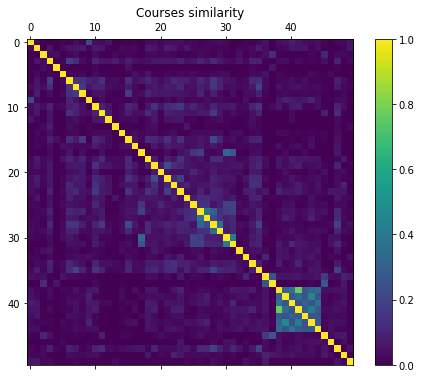

In [18]:
sims = create_similarity_matrix(courses_df, sample_len=50)

fig, ax = plt.subplots(figsize=(8, 6))

cax = ax.matshow(sims, interpolation='nearest')
fig.colorbar(cax)
ax.set_title('Courses similarity')

plt.show();

The similarity dataframe will look like this:

In [19]:
sims_df_s50 = create_similarity_df(courses_df, sample_len=50)
sims_df_s50.head()

,a_course_id,another_course_id,similarity
0,170037187,170037258,0.772166
1,170037258,170037187,0.772166


### 6.1 Create courses content similarity DataFrame
And now, I will create the similarities dataframe with the entire courses dataframe. <span style="color:red">**This process took approximately 8 hours on a MacBook pro (2.3 GHz Intel Core i5, 16 GB RAM)**</span>

In [20]:
sims_df = create_similarity_df(courses_df)

In [27]:
sims_df.head()

,a_course_id,another_course_id,similarity
0,170565193,170566126,0.606849
1,170563091,170263714,0.724279
2,170563091,170203253,0.548920
3,170563091,170008122,0.644050
4,170563091,170563098,0.827058


In [28]:
sims_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74110 entries, 0 to 74109
Data columns (total 3 columns):
a_course_id          74110 non-null int64
another_course_id    74110 non-null int64
similarity           74110 non-null float64
dtypes: float64(1), int64(2)
memory usage: 1.7 MB


### 6.2 Save courses similarities into the database

In [29]:
conn = connection()

sql_drop = 'DROP TABLE IF EXISTS `courses_similarities`'
conn.execute(sql_drop)

sql_create = """CREATE TABLE `courses_similarities` (
  `a_course_id` varchar(9) NOT NULL,
  `another_course_id` varchar(9) NOT NULL,
  `similarity` double NOT NULL,
  PRIMARY KEY (`a_course_id`, `another_course_id`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8
"""
conn.execute(sql_create)

# Save course similarities to database
sims_df.to_sql('courses_similarities', con=conn, if_exists='append', index=False)

## 7 Create the user-item matrices
Now, I will create the user item matrices. There will be a matrix relating users to ratings, and another that relates users to leads.

In [5]:
def create_ratings_user_item_matrix(df=reviews_df):
    """Creates a ratings user-item matrix DataFrame reviews

    :return: A DataFrame representing the ratings user-item matrix
    """
    user_items = df[['user_id', 'course_id', 'rating']]

    return user_items.groupby(['user_id', 'course_id'])['rating'].max().unstack()

def create_leads_user_item_matrix(df=leads_df):
    """Creates a leads user-item matrix DataFrame reviews

    :return: A DataFrame representing the leads user-item matrix
    """
    user_items = df[['user_id', 'course_id']]

    user_item_matrix = user_items.groupby(['user_id', 'course_id'])['course_id'].max().unstack()
    user_item_matrix = user_item_matrix.where(user_item_matrix.isnull(), other=1)
    user_item_matrix = user_item_matrix.fillna(0)

    return user_item_matrix

In [9]:
ratings_user_item_matrix = create_ratings_user_item_matrix(reviews_df)
leads_user_item_matrix = create_leads_user_item_matrix(leads_df)

### 7.1 Save the matrices to csv files

In [10]:
leads_user_item_matrix.to_csv('../data/leads_matrix.csv')
ratings_user_item_matrix.to_csv('../data/ratings_matrix.csv')

### 7.2 Checking the files size

In [12]:
leads_file_stats = os.stat('../data/leads_matrix.csv')
ratings_file_stats = os.stat('../data/ratings_matrix.csv')

print('Leads matrix size is {:.2f} MB'.format(leads_file_stats.st_size / (1024 * 1024)))
print('Ratings matrix size is {:.2f} MB'.format(ratings_file_stats.st_size / (1024 * 1024)))

Leads matrix size is 516.91 MB
Ratings matrix size is 254.21 MB


The user-item matrices seems to be too heavy (about 500MB and 255MB) to be loaded  on every request of a web application or an API. To overcome this problem, I will create 'pre-baked' recommendation structures, that is, all recommendations for each user and course. The disadvantage of this strategy is that it will be necessary to execute the generation processes of these structures very frequently to keep the data updated.

**Create a course-course recommendation DataFrame**

This type of recommendation uses the leads generated by users on courses. This will be useful for each course to have a section called "Users who requested information about this course were also interested in...".That section will be very helpful for new users without information request history.

This DataFrame will have two columns: column `course` represents the courses that have generated a lead and column `recommended`, where we will have the courses in which the same user who generated a lead in the courses of column `course` also generated leads.

In [140]:
def course_course_recommendations(course_id, user_item_matrix, max_recs=10):
    """Returns an array of recommended courses based on leads generated in one course

    :param course_id: Course id for which we want to make the recommendations
    :param user_item_matrix: Leads user-item matrix
    :param max_recs: Maximum number of recommendations
    :return numpy.array: Array of courses recommended based on generated leads in one course
    """
    users = np.array(user_item_matrix[user_item_matrix.loc[:, course_id] == 1].index)
    recs = np.array([])

    for user_id in users:
        user_courses = requested_courses(user_id, leads_df)

        new_recs = user_courses[user_courses != course_id]
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))

        if len(recs) > max_recs:
            break

    return recs[:max_recs]

In [17]:
recommendations = []
for course in leads_user_item_matrix.columns:
    recs = course_course_recommendations(course, leads_user_item_matrix)
    for rec in recs:
        recommendations.append({'course': course, 'recommended': rec})

course_course_recs_df = pd.DataFrame(recommendations)

In [18]:
course_course_recs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29469 entries, 0 to 29468
Data columns (total 2 columns):
course         29469 non-null object
recommended    29469 non-null object
dtypes: object(2)
memory usage: 460.5+ KB


**Save recommendations to database**

In [19]:
conn = connection()

sql_drop = 'DROP TABLE IF EXISTS `recommended_courses_by_leads`'
conn.execute(sql_drop)

sql_create = """CREATE TABLE `recommended_courses_by_leads` (
  `course` varchar(9) NOT NULL,
  `recommended` varchar(9) NOT NULL,
  PRIMARY KEY (`course`, `recommended`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8
"""
conn.execute(sql_create)

# Save recommendations to database
course_course_recs_df.to_sql('recommended_courses_by_leads', con=conn, if_exists='append', index=False)

## 8 Neighborhood based collaborative filtering using leads data
### 8.1 The matrix sparsity problem
If we want to recommend courses to a user based on leads generated by other users, the problem gets worse. We have a matrix with 26186 users and 10331 courses, so we have more than 270 million cells, most of which with zero value (only 37085 filled with non-zero values).

In [20]:
leads_user_item_matrix.shape

(26186, 10331)

In [21]:
leads_user_item_matrix.shape[0] * leads_user_item_matrix.shape[1]

270527566

In [22]:
# Count non-zero values
(leads_user_item_matrix != 0).sum().sum()

37085

This causes two problems:

As I said before, we would need around 500MB memory to store the matrix. The second problem is that we need to perform operations on this matrix and the execution time of these operations would be very long.

Since the bulk of the computation performed will involve adding or multiplying zero values together, we could perform the calculations only when there is a connection between the user and the course, that is when the cell value is 1.

The solution to representing and working with sparse matrices is to use an alternate data structure to represent the sparse data.

SciPy provides an [implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) for creating sparse matrix from multiple structures.

I will create a sparse matrix from the `leads_user_item_matrix`:

In [23]:
sp_user_item_matrix = csr_matrix(leads_user_item_matrix.values, dtype='int8')
sp_user_item_matrix

<26186x10331 sparse matrix of type '<class 'numpy.int8'>'
	with 37085 stored elements in Compressed Sparse Row format>

In [24]:
print(sp_user_item_matrix)

  (0, 6556)	1
  (0, 6864)	1
  (0, 8165)	1
  (0, 9224)	1
  (1, 5944)	1
  (2, 8081)	1
  (3, 10232)	1
  (4, 10059)	1
  (5, 8159)	1
  (6, 293)	1
  (7, 6887)	1
  (8, 8843)	1
  (9, 9486)	1
  (10, 9855)	1
  (11, 5926)	1
  (12, 10232)	1
  (13, 10041)	1
  (14, 9094)	1
  (15, 4456)	1
  (16, 10041)	1
  (17, 10244)	1
  (18, 9181)	1
  (19, 1708)	1
  (19, 3784)	1
  (19, 3793)	1
  :	:
  (26163, 9055)	1
  (26164, 6535)	1
  (26165, 2569)	1
  (26166, 3669)	1
  (26167, 9058)	1
  (26168, 6090)	1
  (26169, 91)	1
  (26170, 9181)	1
  (26171, 3068)	1
  (26172, 10283)	1
  (26173, 7578)	1
  (26174, 10244)	1
  (26175, 10035)	1
  (26176, 1629)	1
  (26177, 2175)	1
  (26178, 1730)	1
  (26179, 9181)	1
  (26180, 3103)	1
  (26180, 9896)	1
  (26181, 7339)	1
  (26182, 9655)	1
  (26183, 6611)	1
  (26184, 10198)	1
  (26185, 365)	1
  (26185, 3825)	1


We see how the csr_matrix looks, the first element of tuple is the row index (users) and the second one is the column (courses) the value represents the relation between users and courses, in this case all values are 1.

The next step is to create a user-courses map, a dictionary whose keys are user ids and values ​​the matrix corresponding to that user.

In [25]:
user_leads_courses_map = {}
for i in range(0, sp_user_item_matrix.shape[0]):
    user_leads_courses_map[leads_user_item_matrix.index[i]] = sp_user_item_matrix[i]

In [26]:
with open('../data/user_courses_map.pickle', 'wb') as filename:
    pickle.dump(user_leads_courses_map, filename)


In [27]:
file = os.stat('../data/user_courses_map.pickle')

print('Leads matrix size is {:.2f} MB'.format(file.st_size / (1024 * 1024)))

Leads matrix size is 6.38 MB


6.38 MB vs. 516.91 MB, the improvement is amazing.

## 9 Neighborhood based collaborative filtering using ratings

### 9.1 Measuring distances between users

To get the nearest neighbours of each user, I need to calculate the distance between each user and every other user. To get this measure, I will use the Euclidean Distance.

In [112]:
def rated_courses(user_id):
    """Returns an array of course ids rated by a user
    
    :param user_id: User identifier
    :return: Array of courses rated by a user
    """
    return reviews_df[reviews_df['user_id'] == user_id]['course_id'].values

def courses_liked(user_id, min_rating=7):
    """Returns an array of courses rated by a user with a rating higher than `min_rating`
    
    :param user_id str: User id for which we want to find courses rated
                          
    :return array: Array of course ids rated by a user
    """
    return reviews_df[(reviews_df['user_id'] == user_id) & (reviews_df['rating'] >= min_rating)]['course_id'].values

In [113]:
def compute_euclidean_distance(a_user_id, another_user_id, ratings_user_item_matrix):
    """Computes the euclidean distance between users taking into account the rated courses
    
    :param a_user_id str: Id of a user
    :param another_user_id str: Id of another user
    :param user_item_matrix DataFrame: The reviews user-item matrix
    :return float: The eculidean distance between the users
    """
    a_user_courses = rated_courses(a_user_id)
    another_user_courses = rated_courses(another_user_id)
    
    similar_courses = np.intersect1d(a_user_courses,
                                     another_user_courses, 
                                     assume_unique=True)
    
    # there's no courses in common
    if len(similar_courses) == 0:
        return np.nan
    
    df = ratings_user_item_matrix.loc[(a_user_id, another_user_id), similar_courses]
    
    return np.linalg.norm(df.loc[a_user_id] - df.loc[another_user_id])


**Create a user distances DataFrame**

<span style="color:red">**This process consumes a lot of time and resources**</span>

In [114]:
distances = []

for user_id in ratings_user_item_matrix.index:
    for another_user_id in ratings_user_item_matrix.index:
        if user_id == another_user_id:
            continue
            
        try: 
            distance = compute_euclidean_distance(user_id,
                                                  another_user_id,
                                                  ratings_user_item_matrix)
        except KeyError:
            continue

        if np.isnan(distance):
            continue

        distances.append({'a_user_id': user_id, 'another_user_id': another_user_id, 'eucl_distance': distance})
        
eucl_distances_df = pd.DataFrame(distances)

In [115]:
eucl_distances_df.head()

,a_user_id,another_user_id,eucl_distance
0,0006246bee639c7a7b11a08e34dd3cc6,04fe53ba19edf4c5dac738fc5a75266e,1.0
1,0006246bee639c7a7b11a08e34dd3cc6,2d776f635af2685af7b556b3bf270c33,1.0
2,0006246bee639c7a7b11a08e34dd3cc6,2d85fe69a230d106d7a9052381a09356,2.0


**Save the DataFrame to database**

In [148]:
conn = connection()

sql_drop = 'DROP TABLE IF EXISTS `users_distances`'
conn.execute(sql_drop)

sql_create = """CREATE TABLE `users_distances` (
  `a_user_id` char(36) NOT NULL,
  `another_user_id` char(36) NOT NULL,
  `eucl_distance` double NOT NULL,
  PRIMARY KEY (`a_user_id`, `another_user_id`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8
"""
conn.execute(sql_create)

# Save distances to database
eucl_distances_df.to_sql('users_distances', con=conn, if_exists='append', index=False)